Sentiment Analysis using LSTM with pretrained GloVe model on custome dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
pashtoText= pd.read_csv('PashtoCorpusUpdated.csv')

In [4]:
pashtoText.head()

,Id,Source,Topic,PashtoText,EnglishtTranslation,AnnotatorOne,AnnotatorTwo
0,1,https://www.facebook.com/167959249906191/posts...,افغان ولسمشر محمد اشرف غني ویلي، په اوسنیو شرا...,د لیوني څخه پوښتنه د یو لیونی څخه یو چا پوښتنه...,Question from a madman Someone asked that grie...,Negative,Negative
1,2,NaN,Afghan President Mohammad Ashraf Ghani said th...,جهالت د نابالغه ماشومانو په باچا پورې خندل نه...,"Ignorance of immature children ,If you don't l...",Positive,Positive
2,3,NaN,NaN,ماته خو بی خوبه خکاری نور نه پو هیږم,I like it but I don't know anymore,Positive,Positive
3,4,NaN,NaN,عنى ځان لپاره عمحوار دى نه د وطن حلکو لپاره دا...,Ghani is a leader for himself and not for the ...,Negative,Negative
4,5,NaN,NaN,خپله سه بلا وهلي یی ړوزي خو نه دي چي کوي یی,what happened with you. This is not joking tha...,Negative,Negative


In [5]:
pashtoText.drop(["Id","Source", "Topic", "PashtoText", "AnnotatorTwo"], axis=1, inplace=True)

In [6]:
pashtoText['EnglishtTranslation'] = pashtoText['EnglishtTranslation'].astype('string')
pashtoText['AnnotatorOne'] = pashtoText['AnnotatorOne'].astype('string')

In [7]:
pashtoText.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   EnglishtTranslation  600 non-null    string
 1   AnnotatorOne         600 non-null    string
dtypes: string(2)
memory usage: 9.5 KB


In [8]:
# covert string into numerical of reviewe attr
labels = {"Positive": 1, "Negative": 0}
pashtoText['AnnotatorOne'] = pashtoText['AnnotatorOne'].map(labels)
pashtoText.head()

,EnglishtTranslation,AnnotatorOne
0,Question from a madman Someone asked that grie...,0
1,"Ignorance of immature children ,If you don't l...",1
2,I like it but I don't know anymore,1
3,Ghani is a leader for himself and not for the ...,0
4,what happened with you. This is not joking tha...,0


In [9]:
from nltk.corpus import stopwords # to remove the stopwrods
from nltk.stem.porter import PorterStemmer # steam to root word every
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
import re
steamer = PorterStemmer()

In [10]:
# clean the text data
def preprocessText(text):
    # remove non-alphabetic characters
    text = re.sub('[^A-Za-z]', ' ', text)
    # convert to lowercase
    text = text.lower()
    # remove stopwords
    stopWords = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if not word in stopWords]
    # join the words back into a string
    text = ' '.join(words)
    return text

In [11]:
x = []
words = list(pashtoText['EnglishtTranslation'])
for i in words:
    x.append(preprocessText(i))

In [12]:
x[1]

'ignorance immature children laugh king ghani pride ghani leader ghani mourner country'

In [14]:
y = pashtoText['AnnotatorOne']

In [15]:
y

0      0
1      1
2      1
3      0
4      0
      ..
595    0
596    1
597    1
598    1
599    1
Name: AnnotatorOne, Length: 600, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing set
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [17]:
from keras_preprocessing.text import Tokenizer
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xTrain)

In [18]:
xTrain = tokenizer.texts_to_sequences(xTrain)
xTest = tokenizer.texts_to_sequences(xTest)

In [19]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocabLen = len(tokenizer.word_index) + 1
vocabLen 

1079

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 35
xTrain = pad_sequences(xTrain, padding='post', maxlen=max_len)
xTest = pad_sequences(xTest, padding='post', maxlen=max_len)

In [26]:
# tokenizer.word_index.items()

In [27]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
# C:\Users\Toshiba\Desktop\New folder\deepLearning\r nn\glove.6B.100d.txt
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [28]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocabLen, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [29]:
embedding_matrix.shape

(1079, 100)

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

<!-- for regularization 
lstmModel.add(LSTM(64, activation='tanh', input_dim=32, kernel_regularizer = tf.keras.regularizers.l1(0.001)))
 -->

In [44]:
lstmModel = Sequential()
embeddedLayer = Embedding(vocabLen, 100, weights=[embedding_matrix], input_length=max_len , trainable=False)
lstmModel.add(embeddedLayer)
lstmModel.add(Dropout(0.5))
lstmModel.add(LSTM(128))
lstmModel.add(Dropout(0.5))
lstmModel.add(Dense(1, activation='sigmoid'))

In [45]:
from tensorflow.keras.optimizers import Adam

# Define the learning rate
lr = 0.001

# Define the optimizer with the learning rate
# optimizer = Adam(lr=lr)
lstmModel.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['accuracy'])
lstmModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           107900    
                                                                 
 dropout_2 (Dropout)         (None, 35, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 225,277
Trainable params: 117,377
Non-trainable params: 107,900
_________________________________________________________________


In [46]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience= 6,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [47]:
history = lstmModel.fit(xTrain, yTrain, epochs=15, batch_size=90, callbacks=[callback], validation_split = 0.2)

Epoch 1/15
5/5 [==============================] - 7s 414ms/step - loss: 0.6917 - accuracy: 0.5755 - val_loss: 0.6848 - val_accuracy: 0.6354
Epoch 2/15
5/5 [==============================] - 1s 142ms/step - loss: 0.6825 - accuracy: 0.6094 - val_loss: 0.6689 - val_accuracy: 0.6354
Epoch 3/15
5/5 [==============================] - 1s 138ms/step - loss: 0.6659 - accuracy: 0.6094 - val_loss: 0.6442 - val_accuracy: 0.6354
Epoch 4/15
5/5 [==============================] - 1s 152ms/step - loss: 0.6364 - accuracy: 0.6224 - val_loss: 0.6653 - val_accuracy: 0.5938
Epoch 5/15
5/5 [==============================] - 1s 142ms/step - loss: 0.6137 - accuracy: 0.6484 - val_loss: 0.5869 - val_accuracy: 0.6667
Epoch 6/15
5/5 [==============================] - 1s 150ms/step - loss: 0.5608 - accuracy: 0.7031 - val_loss: 0.5179 - val_accuracy: 0.7396
Epoch 7/15
5/5 [==============================] - 1s 156ms/step - loss: 0.5170 - accuracy: 0.7734 - val_loss: 0.5010 - val_accuracy: 0.7917
Epoch 8/15
5/5 [====

In [55]:
score = lstmModel.evaluate(xTest, yTest, verbose=1)
print("Test Accuracy:", score[1])

4/4 [==============================] - 0s 32ms/step - loss: 0.5513 - accuracy: 0.7250
Test Accuracy: 0.7250000238418579


In [50]:
len(history.history['loss']) # # Only 4 epochs are run.

15

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

# make predictions on the testing set
yPred = lstmModel.predict(xTest)
yPred = [1 if p >= 0.5 else 0 for p in yPred]

# generate classification report and confusion matrix
print(classification_report(yTest, yPred))
print(confusion_matrix(yTest, yPred))

4/4 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        58
           1       0.70      0.81      0.75        62

    accuracy                           0.73       120
   macro avg       0.73      0.72      0.72       120
weighted avg       0.73      0.72      0.72       120

[[37 21]
 [12 50]]


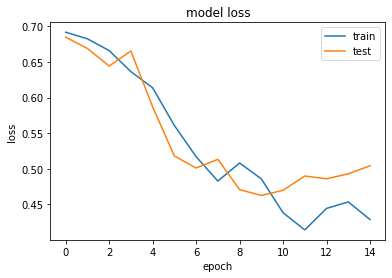

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

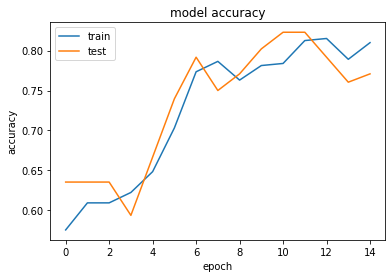

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [54]:
# assume your new sentence is stored in a variable called new_sentence
new_sentence = "Ghani was good"

# preprocess the text
new_sentence = preprocessText(new_sentence)

# tokenize and pad the sequence
new_sentence_seq = tokenizer.texts_to_sequences([new_sentence])
new_sentence_padded = pad_sequences(new_sentence_seq, padding='post', maxlen=max_len)

# make prediction
prediction = lstmModel.predict(new_sentence_padded)[0][0]
if prediction >= 0.5:
    print("Positive")
else:
    print("Negative")


1/1 [==============================] - 0s 32ms/step
Positive
